# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *
from modules.data_import import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam', 'do':.2}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [5]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"))

def reconvert_event(in_data):
    move_to_cartesian(in_data, 'PRI_tau', drop=False)
    move_to_cartesian(in_data, 'PRI_lep', drop=False)
    move_to_cartesian(in_data, 'PRI_jet_leading', drop=False)
    move_to_cartesian(in_data, 'PRI_jet_subleading', drop=False)
    move_to_cartesian(in_data, 'PRI_met', z=False)

id = 19
nom = pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1]

z_flip = nom.copy()
z_flip_event(z_flip)
reconvert_event(z_flip)

rot = nom.copy()
rotate_event(rot)
reconvert_event(rot)

rot_y = nom.copy()
rotate_event(rot_y)
y_flip_event(rot_y)
reconvert_event(rot_y)

rot_yz = nom.copy()
rotate_event(rot_yz)
y_flip_event(rot_yz)
z_flip_event(rot_yz)
reconvert_event(rot_yz)

comp_events([nom, rot, rot_y, rot_yz])

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


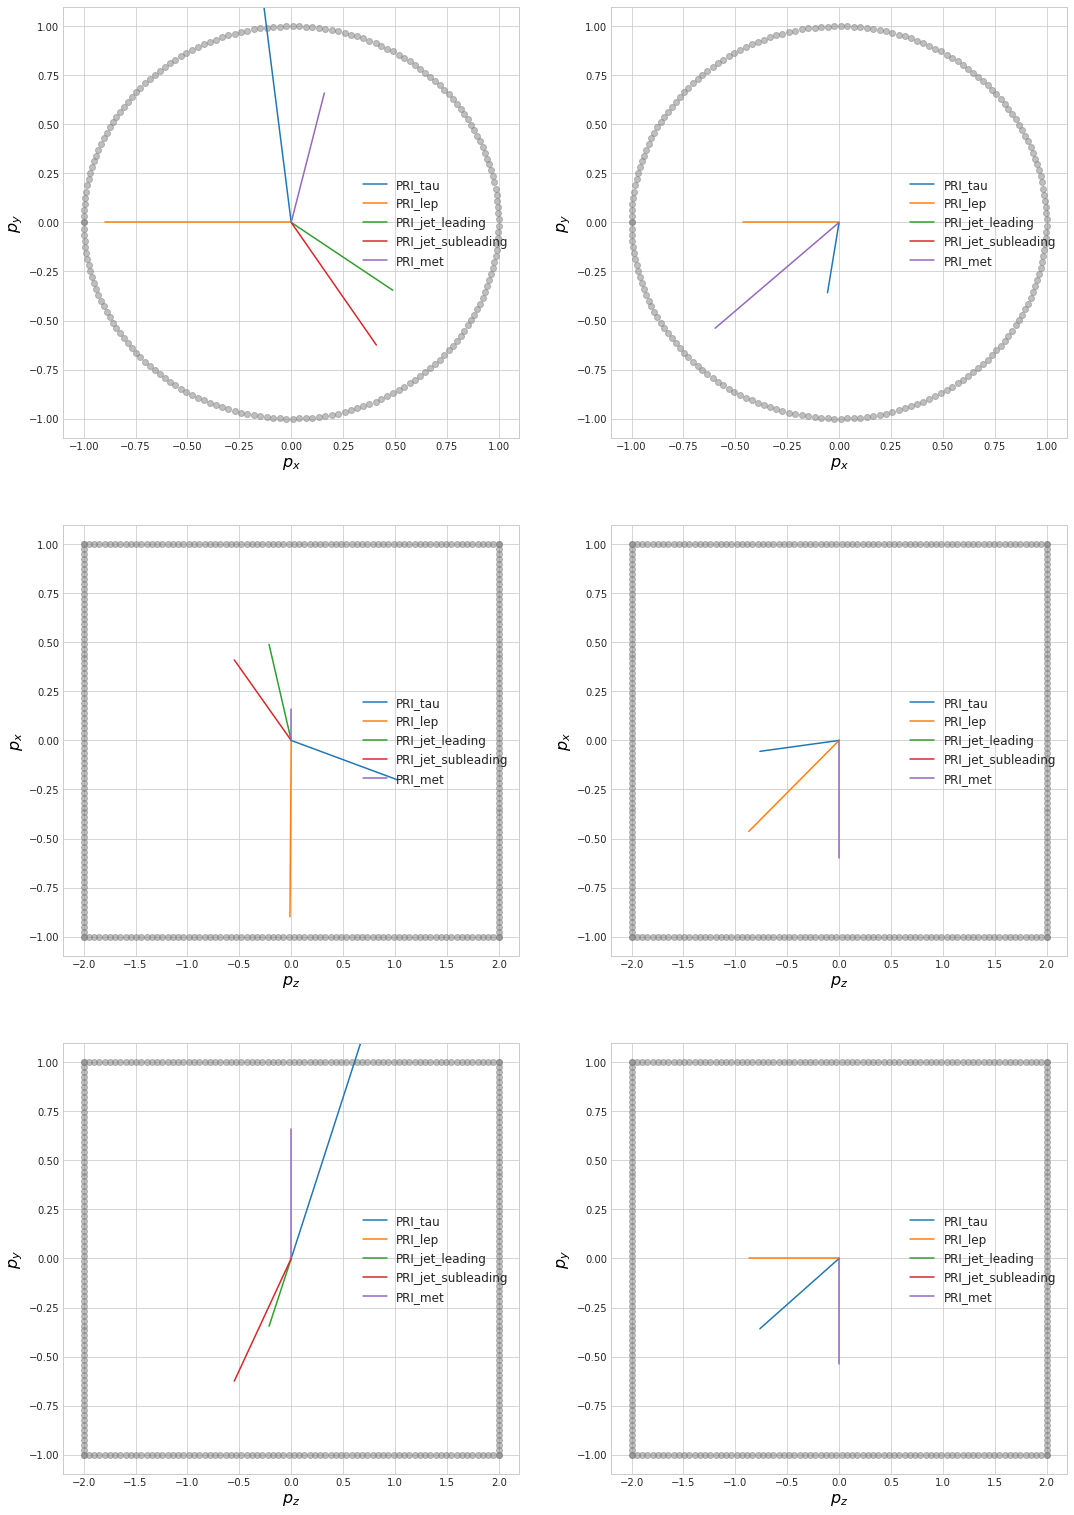

In [6]:
id = 0
pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1]
comp_events([pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1],
             pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id+1:id+2]])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 20.949s 


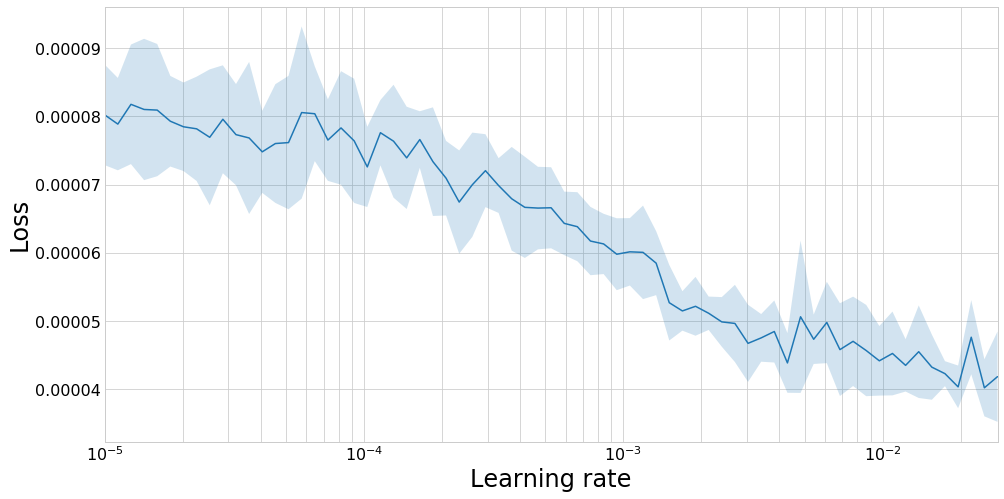

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [8]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

In [9]:
model_gen_params

{'version': 'modelSwish',
 'n_in': 30,
 'compile_args': {'loss': 'binary_crossentropy',
  'optimizer': 'adam',
  'do': 0.2,
  'lr': 0.002,
  'amsgrad': False,
  'beta_1': 0.9},
 'mode': 'classifier'}

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149493). Check your callbacks.
  % delta_t_median)


1 New best found: 3.887053611299238e-05
2 New best found: 3.6285671290363306e-05
3 New best found: 3.557508210496128e-05
4 New best found: 3.5165413930104175e-05
5 New best found: 3.441173637610734e-05
6 New best found: 3.4023624279006354e-05
7 New best found: 3.396911853126606e-05
8 New best found: 3.379300591262502e-05
9 New best found: 3.370636892474009e-05
10 New best found: 3.356558250527223e-05
11 New best found: 3.3140587992120404e-05
12 New best found: 3.3076306164714105e-05
13 New best found: 3.295524231805871e-05
14 New best found: 3.29209195650954e-05
15 New best found: 3.29183822738081e-05
20 New best found: 3.2734937319084255e-05
22 New best found: 3.2687012914697016e-05
24 New best found: 3.2655601599271543e-05
25 New best found: 3.260256596054517e-05
26 New best found: 3.2374241915025506e-05
27 New best found: 3.23686756351896e-05
29 New best found: 3.2362572762778774e-05
30 New best found: 3.235782420199384e-05
44 New best found: 3.218041558446331e-05
50 New best found:

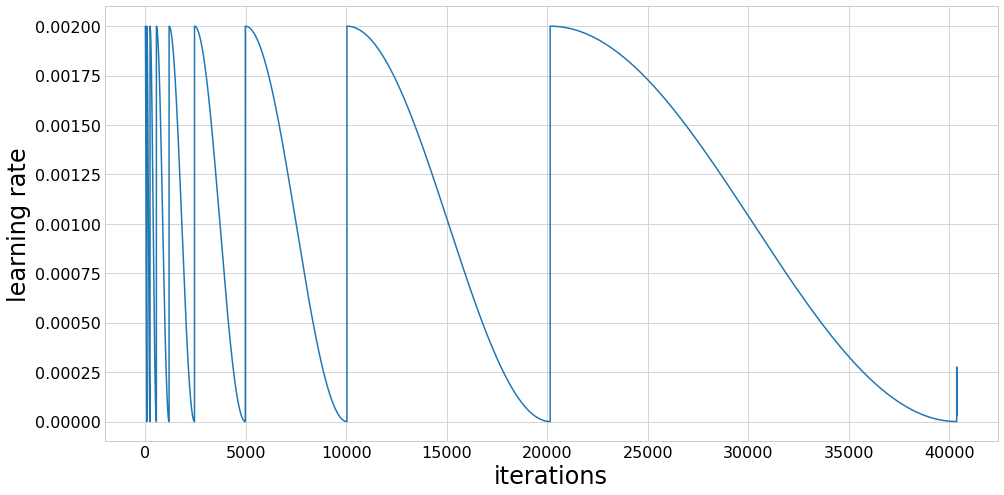

Fold took 456.914s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142236). Check your callbacks.
  % delta_t_median)


1 New best found: 3.993086384120486e-05
2 New best found: 3.664694670187504e-05
3 New best found: 3.625452678962735e-05
4 New best found: 3.5490732544298645e-05
5 New best found: 3.46192025681481e-05
6 New best found: 3.4468271091788906e-05
8 New best found: 3.435667585160488e-05
9 New best found: 3.417228189694955e-05
10 New best found: 3.4063641148098814e-05
11 New best found: 3.376774209277416e-05
12 New best found: 3.353359514722863e-05
13 New best found: 3.3387672462499866e-05
14 New best found: 3.338735920998842e-05
15 New best found: 3.337531473941287e-05
21 New best found: 3.325746404732716e-05
22 New best found: 3.3191584020252116e-05
23 New best found: 3.3017573629780285e-05
24 New best found: 3.3006329177318516e-05
25 New best found: 3.290550693511736e-05
26 New best found: 3.289584000055647e-05
28 New best found: 3.285300422120833e-05
30 New best found: 3.284384035576422e-05
31 New best found: 3.284076664072988e-05
39 New best found: 3.275450686846107e-05
44 New best found:

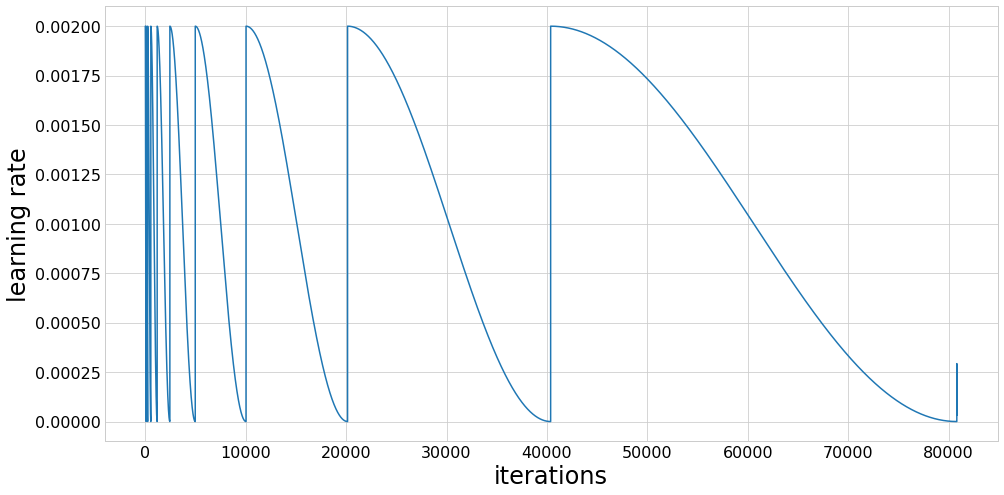

Fold took 917.201s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160867). Check your callbacks.
  % delta_t_median)


1 New best found: 3.970746885623689e-05
2 New best found: 3.643990103386849e-05
3 New best found: 3.5734389368582116e-05
4 New best found: 3.518751432425925e-05
5 New best found: 3.42591764863257e-05
6 New best found: 3.3979368927031815e-05
7 New best found: 3.394978469873589e-05
8 New best found: 3.384244444829088e-05
9 New best found: 3.357665332881683e-05
11 New best found: 3.333895878744646e-05
12 New best found: 3.31777465990021e-05
13 New best found: 3.306978470049245e-05
14 New best found: 3.2912857057774014e-05
15 New best found: 3.290630562776936e-05
21 New best found: 3.282712958756238e-05
23 New best found: 3.2684881694489175e-05
24 New best found: 3.2546638075701105e-05
25 New best found: 3.2496061766677e-05
26 New best found: 3.234271242155871e-05
28 New best found: 3.2303302993261996e-05
46 New best found: 3.2206783622363494e-05
50 New best found: 3.2119847604641275e-05
52 New best found: 3.210033052985969e-05
53 New best found: 3.205264087106746e-05
55 New best found: 3.

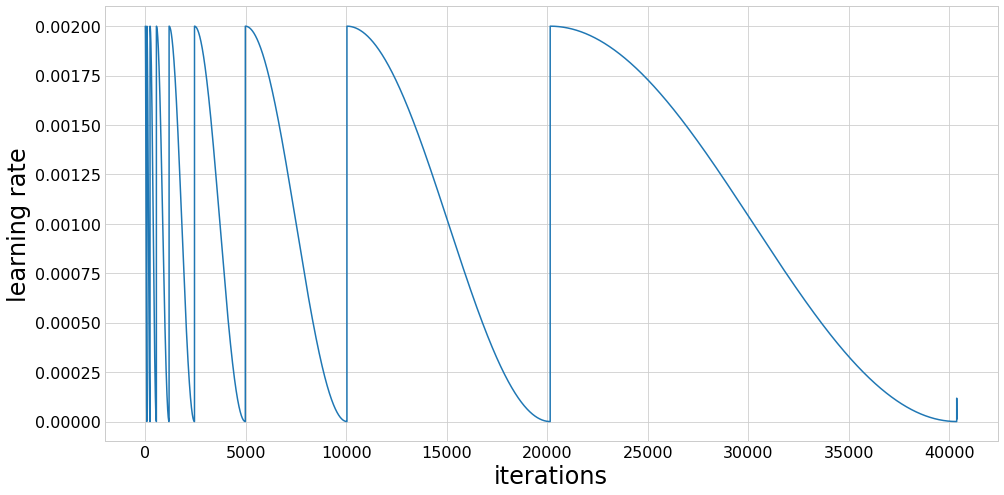

Fold took 470.556s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.403825). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202288). Check your callbacks.
  % delta_t_median)


1 New best found: 3.842578871990554e-05
2 New best found: 3.54971802138607e-05
3 New best found: 3.5055199249472934e-05
4 New best found: 3.461671695258701e-05
5 New best found: 3.417178859672276e-05
6 New best found: 3.4158274752553554e-05
7 New best found: 3.395423249749001e-05
9 New best found: 3.36556742186076e-05
10 New best found: 3.341641864099074e-05
11 New best found: 3.333127222576877e-05
12 New best found: 3.3261980964744e-05
13 New best found: 3.3177047998469786e-05
19 New best found: 3.292699612939032e-05
21 New best found: 3.290941366722109e-05
24 New best found: 3.290843710128684e-05
25 New best found: 3.290840311674401e-05
26 New best found: 3.286668972868938e-05
27 New best found: 3.274164617760107e-05
28 New best found: 3.2737838993489275e-05
29 New best found: 3.2728902700182516e-05
30 New best found: 3.270822016784223e-05
31 New best found: 3.270481660438236e-05
43 New best found: 3.255213272641413e-05
48 New best found: 3.2543784215522466e-05
52 New best found: 3.2

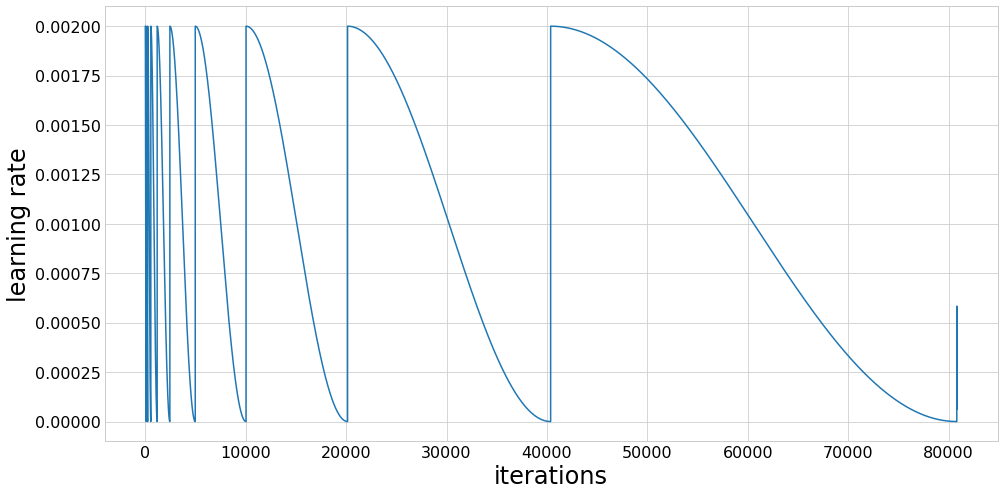

Fold took 946.873s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.453770). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227282). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8107600413786715e-05
2 New best found: 3.598371900152415e-05
3 New best found: 3.5514215889270415e-05
4 New best found: 3.509940540825482e-05
5 New best found: 3.48108268881333e-05
6 New best found: 3.410656275809743e-05
7 New best found: 3.4075664235570005e-05
9 New best found: 3.39057906268863e-05
11 New best found: 3.3603001454321205e-05
12 New best found: 3.331074944435386e-05
13 New best found: 3.3302711829310286e-05
14 New best found: 3.321471372328233e-05
15 New best found: 3.318767158780247e-05
22 New best found: 3.293050552601926e-05
24 New best found: 3.26881099405e-05
28 New best found: 3.2622076974075755e-05
29 New best found: 3.257211504533188e-05
30 New best found: 3.256328013230814e-05
31 New best found: 3.255992466874886e-05
43 New best found: 3.255278616561554e-05
44 New best found: 3.254247508593835e-05
45 New best found: 3.247594532876974e-05
48 New best found: 3.239722639409592e-05
50 New best found: 3.231452843610896e-05
51 New best found: 3.225

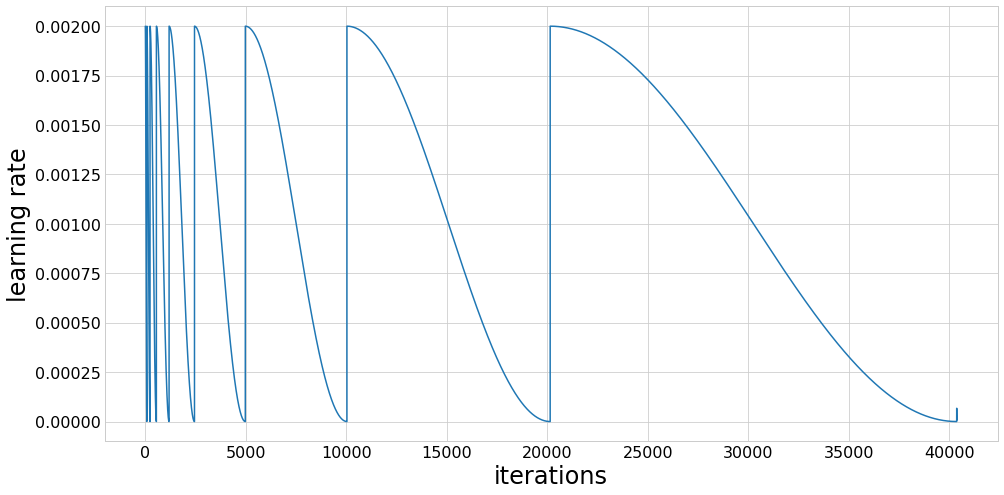

Fold took 489.882s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.494922). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247807). Check your callbacks.
  % delta_t_median)


1 New best found: 3.804625625793283e-05
2 New best found: 3.494588290429437e-05
3 New best found: 3.441101720265861e-05
4 New best found: 3.355652181626625e-05
5 New best found: 3.306301752981092e-05
6 New best found: 3.275362404390362e-05
7 New best found: 3.266453732400788e-05
9 New best found: 3.263394334098104e-05
10 New best found: 3.209214037790363e-05
11 New best found: 3.1791086746055185e-05
12 New best found: 3.169580019762775e-05
13 New best found: 3.1570968166552155e-05
14 New best found: 3.153609644247203e-05
15 New best found: 3.1525469162265157e-05
21 New best found: 3.1521351521563646e-05
22 New best found: 3.130260476855607e-05
24 New best found: 3.119299952515198e-05
25 New best found: 3.114227654299728e-05
27 New best found: 3.1051084335545876e-05
29 New best found: 3.1008429978950474e-05
30 New best found: 3.099962669702972e-05
31 New best found: 3.0995751001472047e-05
42 New best found: 3.0921686071570267e-05
43 New best found: 3.090358191004043e-05
49 New best foun

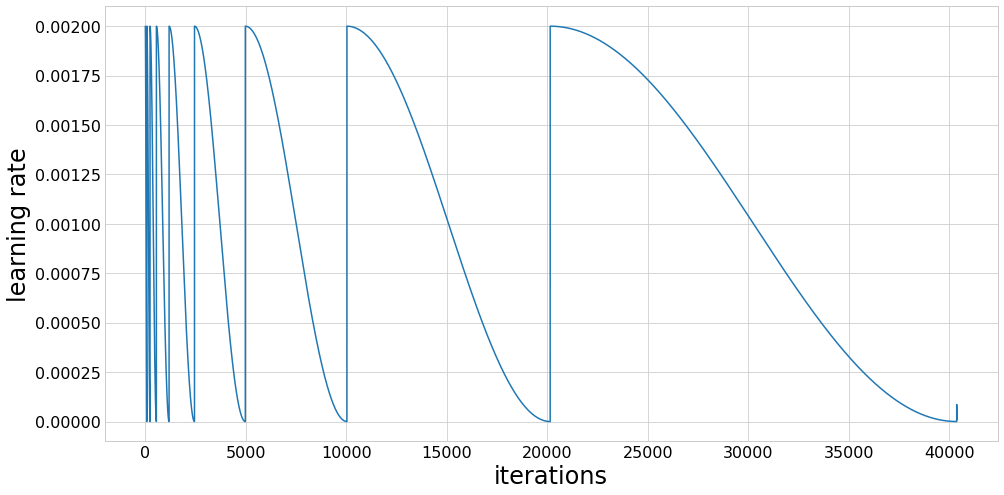

Fold took 495.217s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.513493). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257111). Check your callbacks.
  % delta_t_median)


1 New best found: 3.951032178784876e-05
2 New best found: 3.699721109632245e-05
3 New best found: 3.636528399841171e-05
4 New best found: 3.578484048858697e-05
5 New best found: 3.5655244483309645e-05
6 New best found: 3.484238183282126e-05
7 New best found: 3.48348317502569e-05
8 New best found: 3.4767299629775575e-05
9 New best found: 3.452773326290313e-05
10 New best found: 3.413660368517797e-05
12 New best found: 3.408488020614268e-05
13 New best found: 3.388319527344672e-05
14 New best found: 3.387094253090056e-05
15 New best found: 3.3841597067088414e-05
17 New best found: 3.382395787625603e-05
19 New best found: 3.376195726284946e-05
21 New best found: 3.368584200761592e-05
22 New best found: 3.3477903710190866e-05
24 New best found: 3.345096123515933e-05
25 New best found: 3.341866143568192e-05
26 New best found: 3.3232097531329194e-05
27 New best found: 3.318597580493027e-05
42 New best found: 3.3125965893063074e-05
45 New best found: 3.312407942369126e-05
49 New best found: 3

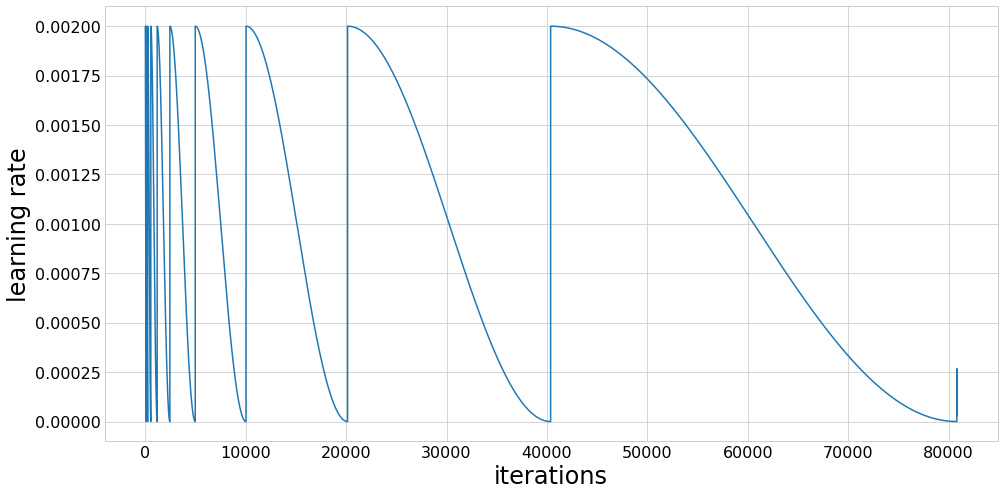

Fold took 988.402s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.523488). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.262226). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8570632461545855e-05
2 New best found: 3.566660631742567e-05
3 New best found: 3.5364499889457826e-05
4 New best found: 3.433979796605669e-05
5 New best found: 3.3806541718045714e-05
6 New best found: 3.3352988518649784e-05
7 New best found: 3.322955308749467e-05
9 New best found: 3.2757533278106005e-05
11 New best found: 3.2740631572283494e-05
12 New best found: 3.236122044791825e-05
13 New best found: 3.227039051988001e-05
18 New best found: 3.221799277497119e-05
19 New best found: 3.187757451232035e-05
25 New best found: 3.1677165085118124e-05
28 New best found: 3.161211519073872e-05
29 New best found: 3.157761015861737e-05
31 New best found: 3.157676251282966e-05
45 New best found: 3.1521609721240326e-05
46 New best found: 3.1456042143422587e-05
47 New best found: 3.142863018157776e-05
48 New best found: 3.139708032690113e-05
51 New best found: 3.1346043267742865e-05
52 New best found: 3.126714207929961e-05
55 New best found: 3.122029470455574e-05
56 New best fo

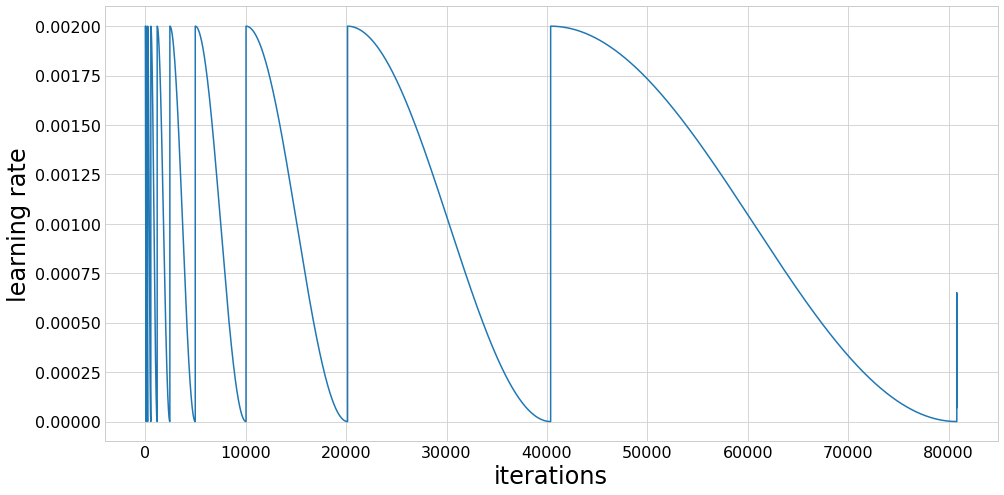

Fold took 1008.966s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.546670). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.273725). Check your callbacks.
  % delta_t_median)


1 New best found: 3.937886556377634e-05
2 New best found: 3.640386107435916e-05
3 New best found: 3.629316036822274e-05
4 New best found: 3.537102887348737e-05
5 New best found: 3.507018568925559e-05
6 New best found: 3.47533651147387e-05
7 New best found: 3.467490426410222e-05
8 New best found: 3.457995008502621e-05
9 New best found: 3.4385525368270464e-05
11 New best found: 3.4012653525860516e-05
13 New best found: 3.400979455182096e-05
14 New best found: 3.3893788594286886e-05
15 New best found: 3.384720807807753e-05
18 New best found: 3.365730830701068e-05
23 New best found: 3.348765855480451e-05
24 New best found: 3.3341564088186715e-05
26 New best found: 3.324251169542549e-05
28 New best found: 3.322386303771054e-05
30 New best found: 3.322011439158814e-05
40 New best found: 3.320448964368552e-05
41 New best found: 3.312058870360488e-05
50 New best found: 3.302450575429248e-05
51 New best found: 3.301086395076709e-05
54 New best found: 3.298128085589269e-05
56 New best found: 3.2

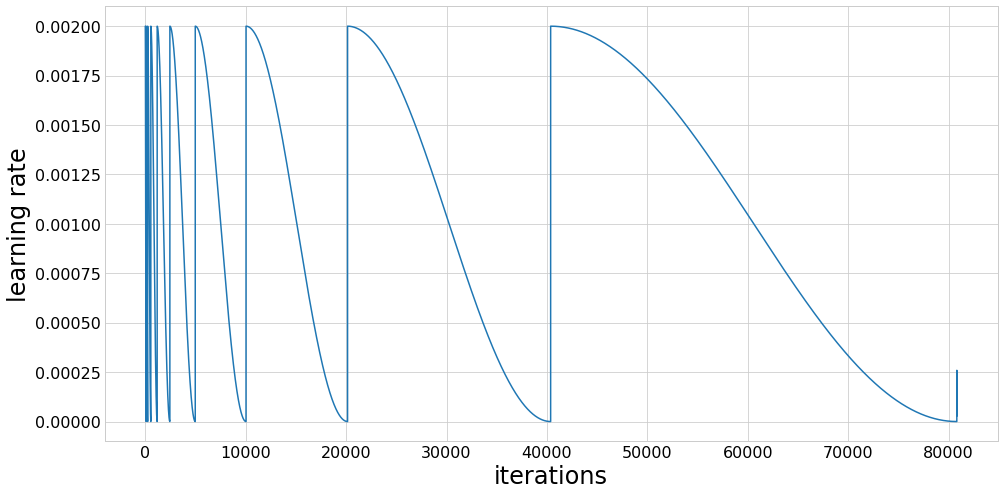

Fold took 1023.818s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.599296). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.300047). Check your callbacks.
  % delta_t_median)


1 New best found: 3.81630721502006e-05
2 New best found: 3.5277790793043097e-05
3 New best found: 3.4768850398540963e-05
4 New best found: 3.439050904999022e-05
5 New best found: 3.362190718034981e-05
6 New best found: 3.341790734266396e-05
7 New best found: 3.3317367659765296e-05
9 New best found: 3.292095936049009e-05
12 New best found: 3.2529280344897416e-05
13 New best found: 3.251376268162858e-05
14 New best found: 3.2459854714397804e-05
15 New best found: 3.2459225886850615e-05
18 New best found: 3.228972273936961e-05
21 New best found: 3.2118996215285734e-05
22 New best found: 3.2081132067833096e-05
25 New best found: 3.195123482582858e-05
26 New best found: 3.187402296607616e-05
27 New best found: 3.181659201654838e-05
43 New best found: 3.1777405182947406e-05
46 New best found: 3.168422560120234e-05
48 New best found: 3.164562913880218e-05
50 New best found: 3.163351096736733e-05
52 New best found: 3.156062777270563e-05
53 New best found: 3.1477616641495844e-05
57 New best fou

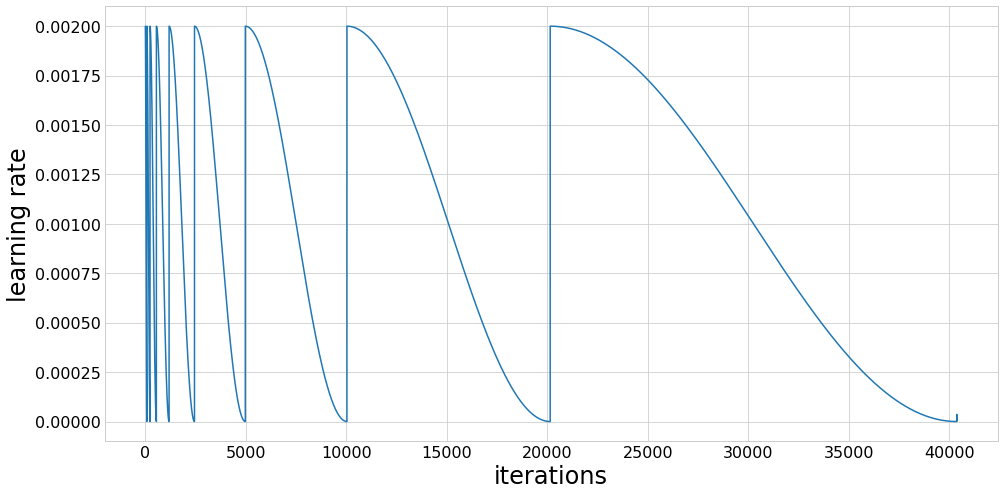

Fold took 530.591s


______________________________________
Training finished
Cross-validation took 7332.584s 


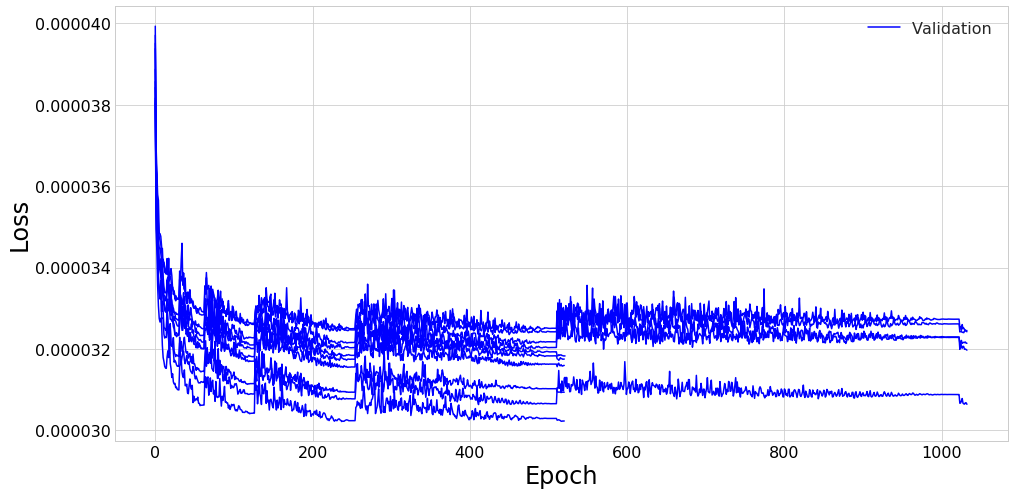

Mean loss = 3.16e-05 +- 2e-07
Mean wAUC = 0.0625 +- 0.0009
Mean AUC = 0.0976 +- 0.0008
Mean AMS = 3.95 +- 0.09
Mean cut = 0.954 +- 0.007
______________________________________



<Figure size 432x288 with 0 Axes>

In [10]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [11]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [12]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 5 with loss = 3.0219718041399817e-05
Model 1 is 7 with loss = 3.0636967040732135e-05
Model 2 is 9 with loss = 3.093955316144275e-05
Model 3 is 0 with loss = 3.154918384166708e-05
Model 4 is 2 with loss = 3.172097030290808e-05
Model 5 is 4 with loss = 3.1829370473860766e-05
Model 6 is 3 with loss = 3.196526703977724e-05
Model 7 is 1 with loss = 3.211112100657703e-05
Model 8 is 8 with loss = 3.2355179102160035e-05
Model 9 is 6 with loss = 3.244547979230904e-05


## Response on validation data without TTA

In [13]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [14]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.002472953451052308s per sample

Predicting fold 2 out of 10
Prediction took 0.0003474095158278942s per sample

Predicting fold 3 out of 10
Prediction took 0.000347372673638165s per sample

Predicting fold 4 out of 10
Prediction took 0.00035592961329966783s per sample

Predicting fold 5 out of 10
Prediction took 0.0003564928703010082s per sample

Predicting fold 6 out of 10
Prediction took 0.0003460592234507203s per sample

Predicting fold 7 out of 10
Prediction took 0.00036233739871531723s per sample

Predicting fold 8 out of 10
Prediction took 0.0003489020168781281s per sample

Predicting fold 9 out of 10
Prediction took 0.0003559954138472676s per sample

Predicting fold 10 out of 10
Prediction took 0.000361229377053678s per sample



In [15]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [16]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9038213893736238, weighted 0.9363718159422965


Best cut at 0.940827546236632 corresponds to AMS of 3.81131939848312
Maximum AMS for data is 3.8606692312185706 at cut of 0.9608398675918579
CPU times: user 25.4 s, sys: 0 ns, total: 25.4 s
Wall time: 25.4 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


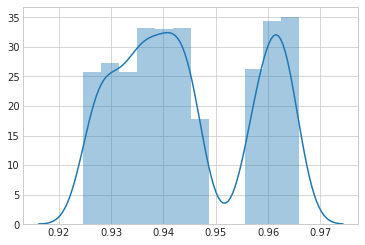

In [17]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.944635 corresponds to AMS of 3.816388654401732
Maximum AMS for data is 3.8606692312185706 at cut of 0.9608398675918579
CPU times: user 88.7 ms, sys: 80.4 ms, total: 169 ms
Wall time: 78.9 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


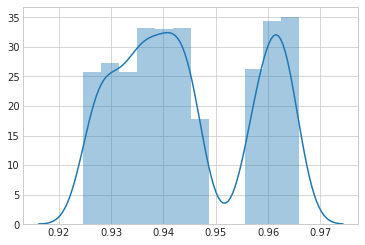

In [18]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [19]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [20]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00034876152280379424s per sample

Predicting fold 2 out of 10
Prediction took 0.0003518895110115409s per sample

Predicting fold 3 out of 10
Prediction took 0.00035279671422798524s per sample

Predicting fold 4 out of 10
Prediction took 0.0003480736082419753s per sample

Predicting fold 5 out of 10
Prediction took 0.00034221950547600334s per sample

Predicting fold 6 out of 10
Prediction took 0.0003432191248136488s per sample

Predicting fold 7 out of 10
Prediction took 0.00034286750678650356s per sample

Predicting fold 8 out of 10
Prediction took 0.0003412700705568899s per sample

Predicting fold 9 out of 10
Prediction took 0.00033846958218650385s per sample

Predicting fold 10 out of 10
Prediction took 0.00033788611523129724s per sample

CPU times: user 3min 47s, sys: 20.2 s, total: 4min 7s
Wall time: 3min 9s


In [21]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.7576428796569417 : 3.7613121274146186


(3.7576428796569417, 3.7613121274146186)

In [22]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.772189081307326 : 3.758233996304031


(3.772189081307326, 3.758233996304031)

In [33]:
score_test_data(test_fy.source, .955)

Public:Private AMS: 3.7935546427005424 : 3.8197880338652017


(3.7935546427005424, 3.8197880338652017)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)